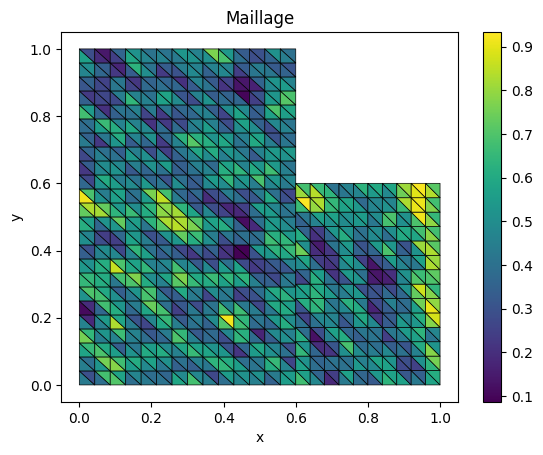

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy.sparse import coo_matrix, diags

# 1.a


def GenerateRectangleMesh(Lx, Ly, Nx, Ny):
    nbr_vtx = (Nx + 1) * (Ny + 1)
    nbr_elt = 2 * Nx * Ny

    vtx = np.zeros((nbr_vtx, 2))
    elt = np.zeros((nbr_elt, 3), dtype=int)

    dx = Lx / Nx
    dy = Ly / Ny

    # Générer les sommets
    vtx_index = 0
    for j in range(Ny + 1):
        for i in range(Nx + 1):
            vtx[vtx_index] = [i * dx, j * dy]
            vtx_index += 1

    # Générer les éléments
    elt_index = 0
    for j in range(Ny):
        for i in range(Nx):
            # Indices des sommets du rectangle courant
            lower_left = j * (Nx + 1) + i
            lower_right = lower_left + 1
            upper_left = lower_left + (Nx + 1)
            upper_right = upper_left + 1

            # Premier triangle
            elt[elt_index] = [lower_left, upper_left, lower_right]
            elt_index += 1

            # Second triangle
            elt[elt_index] = [lower_right, upper_left, upper_right]
            elt_index += 1

    return vtx, elt

# 1.b


def GenerateLShapeMesh(l, N):
    # Calculer le nombre de subdivisions pour chaque sous-domaine
    N1 = int(N * l)
    N2 = N - N1

    # Générer les maillages rectangulaires
    vtx1, elt1 = GenerateRectangleMesh(l,1,N1, N)
    vtx2, elt2 = GenerateRectangleMesh(1.0-l,l,N2, N1)

    # Décaler le deuxième maillage en x
    vtx2[:, 0] += l

    # Combiner les deux maillages
    vtx = np.concatenate((vtx1, vtx2))
    elt2 += len(vtx1)  # mettre à jour les indices des éléments du deuxième maillage
    elt = np.concatenate((elt1, elt2))

    return vtx, elt

# 1.c


def PlotMesh(vtx, elt, val=None):
    plt.figure()

    if val is None:
        plt.triplot(vtx[:, 0], vtx[:, 1], elt)
    else:
        cmap = plt.get_cmap('viridis')
        triang = mtri.Triangulation(vtx[:, 0], vtx[:, 1], elt)
        plt.tripcolor(triang, val, cmap=cmap,
                      shading='flat', edgecolors='k', lw=0.5)
        plt.colorbar()

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Maillage')
    plt.show()

# 2.b


def generate_rig_matrix(vtx, elt):
    nbr_vtx = len(vtx)
    nbr_elt = len(elt)

    # Obtenir les coordonnées des sommets des triangles
    v0 = vtx[elt[:, 0]]
    v1 = vtx[elt[:, 1]]
    v2 = vtx[elt[:, 2]]

    # Calculer les vecteurs des côtés des triangles et les aires des éléments
    e1 = v1 - v0
    e2 = v2 - v0
    areas = 0.5 * np.abs(np.cross(e1, e2))

    # Calculer les gradients locaux
    invA = 1 / (2 * areas)
    b = np.zeros((nbr_elt, 3, 2))
    b[:, 0] = (v2 - v1) * invA[:, None]
    b[:, 1] = (v0 - v2) * invA[:, None]
    b[:, 2] = (v1 - v0) * invA[:, None]

    B = np.einsum('ijk,ilk->ijl', b, b) * areas[:, None, None]

    # Assembler les matrices locales dans la matrice globale
    I = np.repeat(elt[:, :, None], 3, axis=2)
    J = np.repeat(elt[:, None, :], 3, axis=1)
    data = B.flatten()

    # Créer la matrice COO à partir des données assemblées
    K = coo_matrix((data, (I.flatten(), J.flatten())),
                   shape=(nbr_vtx, nbr_vtx))

    return K


def generate_second_matrix(vtx, elt, b):
    nbr_vtx = len(vtx)
    nbr_elt = len(elt)

    # Calculer les matrices de gradients locaux pour chaque élément
    v0 = vtx[elt[:, 0]]
    v1 = vtx[elt[:, 1]]
    v2 = vtx[elt[:, 2]]

    e1 = v1 - v0
    e2 = v2 - v0
    areas = 0.5 * np.abs(np.cross(e1, e2))

    invA = 1 / (2 * areas)
    b_local = np.zeros((nbr_elt, 3, 2))
    b_local[:, 0] = (v2 - v1) * invA[:, None]
    b_local[:, 1] = (v0 - v2) * invA[:, None]
    b_local[:, 2] = (v1 - v0) * invA[:, None]

    C_local = np.einsum('ijk,i->ijk', b_local, b) * areas[:, None, None]

    # Assembler les matrices locales dans la matrice globale
    I = np.repeat(elt[:, :, None], 3, axis=2)
    J = np.repeat(elt[:, None, :], 3, axis=1)
    data = C_local.flatten()

    C = coo_matrix((data, (I.flatten(), J.flatten())),
                   shape=(nbr_vtx, nbr_vtx))

    return C


def generate_mass_matrix(vtx, elt, c):
    # Calculer les aires des éléments
    v0 = vtx[elt[:, 0]]
    v1 = vtx[elt[:, 1]]
    v2 = vtx[elt[:, 2]]

    e1 = v1 - v0
    e2 = v2 - v0
    areas = 0.5 * np.abs(np.cross(e1, e2))

    # Calculer les contributions locales de la matrice de réaction
    local_contrib = (areas * c / 3).repeat(3)

    # Assembler la matrice globale de réaction
    R = diags(local_contrib, shape=(len(vtx), len(vtx)))

    return R

# 2.c


def generate_global_matrix(vtx, elt, b, c):
    return generate_rig_matrix(vtx, elt)+generate_second_matrix(vtx, elt, b)+generate_mass_matrix(vtx, elt, c)


def f_source(x, y, b_x, b_y, p, q, r):
    return np.exp((b_x * x + b_y * y) / 2) * np.sin(p * r * np.pi * x) * np.sin(q * r * np.pi * y)


# 3.a
""" des calculs montrent que alpha=1/(c + bx^2/4 + by^2/4 + (pr%pi)^2 + (qr%pi)^2 )"""

# 3.b


def assemble_source_term(vtx, elt, f):
    n = len(vtx)
    b = np.zeros(n)

    # Parcourir tous les éléments du maillage
    for i in range(len(elt)):
        element = elt[i]

        # Calculer la contribution de chaque élément
        for j in range(3):
            # Récupérer les sommets du triangle
            v1, v2, v3 = vtx[element]

            # Calculer l'aire du triangle
            area = 0.5 * abs((v2[0]-v1[0])*(v3[1]-v1[1]) -
                             (v3[0]-v1[0])*(v2[1]-v1[1]))

            # Calculer le centre du triangle
            centroid = (v1 + v2 + v3) / 3

            # Ajouter la contribution de l'élément à l'intégrale
            b[element[j]] += area * f(*centroid)

    return b
# 3.d


def plot_approximation(vtx, elt, u_h, u_ex_proj):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Afficher la solution numérique u_h
    tri = mtri.Triangulation(vtx[:, 0], vtx[:, 1], triangles=elt)
    plot1 = ax[0].tripcolor(tri, u_h, shading='flat', cmap='viridis')
    fig.colorbar(plot1, ax=ax[0], orientation='vertical', label='u_h')
    ax[0].triplot(tri, 'k--', alpha=0.3)
    ax[0].set_title('Solution numérique u_h')

    # Afficher l'erreur u_h - Π_h u_ex
    error = np.abs(u_h - u_ex_proj)
    plot2 = ax[1].tripcolor(tri, error, shading='flat', cmap='viridis')
    fig.colorbar(plot2, ax=ax[1], orientation='vertical', label='Erreur')
    ax[1].triplot(tri, 'k--', alpha=0.3)
    ax[1].set_title('Erreur u_h - Π_h u_ex')

    plt.tight_layout()
    plt.show()


Lx, Ly, Nx, Ny = 0.7, 0.2, 10, 10

vtx, elt = GenerateLShapeMesh(0.6,24)
PlotMesh(vtx, elt,np.random.rand(vtx.shape[0]))


In [ ]:
#test sur la masse
M=generate_mass_matrix(vtx, elt, 1)
